In [64]:
from diffeq_2 import euler, heun, rku4, verlet, pefrl
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipk, ellipj
from scipy.signal import find_peaks
import timeit
# from scipy.misc import derivative

In [65]:
def analytic(t, theta_0=1, theta_dot0=0):
    m = np.sin(theta_0 / 2)**2
    K = ellipk(m)
    omega_0 = 1
    return 2 * np.arcsin(np.sin(theta_0 / 2) * ellipj(K - omega_0*t, np.sin(theta_0 / 2)**2)[0])

def T_0(theta_0=1.):
    m = np.sin(theta_0 / 2)**2
    K = ellipk(m)
    return 4 * K

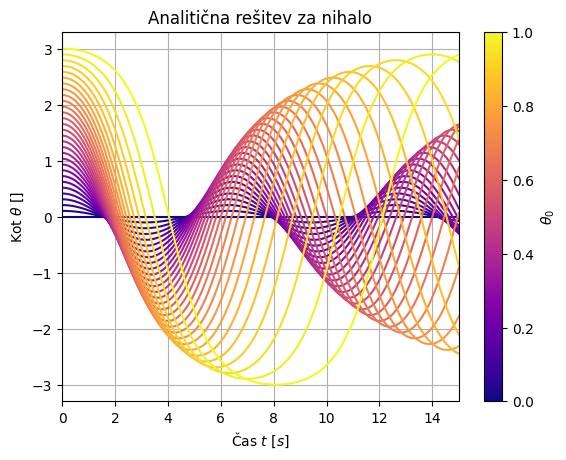

In [66]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

t = np.linspace(0, 15, 1000)

theta = analytic(t)
theta_0s = np.linspace(0, 3, 30)
cmap = plt.colormaps.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(theta_0s)))
fig, ax = plt.subplots()

for i, theta in enumerate(theta_0s):
    ax.plot(t, analytic(t, theta), c=colors[i], label=f'$\\theta_0 = {theta:.2f}$')

sm = ScalarMappable(cmap=cmap)
norm = Normalize(vmin=theta_0s.min(), vmax=theta_0s.max())
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\theta_0$')
plt.grid()
plt.xlim(0, 15)
plt.xlabel('Čas $t\\ [s]$')
plt.ylabel('Kot $\\theta\\ []$')
plt.title('Analitična rešitev za nihalo')
# plt.legend(loc=5)
# plt.colorbar(sm)
plt.savefig('graphs/analytic.pdf', dpi=512)


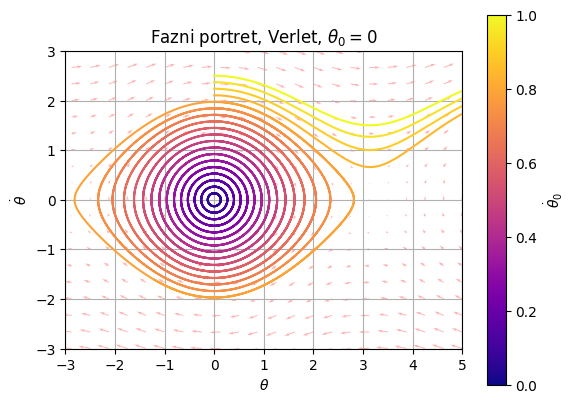

In [67]:
# def prevajanje(y, t, k=np.float64(0.1), T_zun=np.float64(-5)):
#     return - k * (y - T_zun)

def nihanje(theta):
    return -np.sin(theta)

def nihanje_2(y, t):
    return np.array([y[1], -np.sin(y[0])])

fig, ax = plt.subplots()


theta_range = np.linspace(-4, 5, 25)
p_range = np.linspace(-4, 4, 25)

theta_pika = p_range
p_pika = -np.sin(theta_range)

U, V = np.meshgrid(theta_range, p_range)

U_copy = U.copy()
U = V
V = -np.sin(U_copy)

ax.quiver(theta_range, p_range, U, V, alpha=0.3, color='r')

t = np.arange(0, 20, 0.01)

theta_dot0s = np.linspace(0, 2.5, 20)
cmap = plt.colormaps.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(theta_dot0s)))

for i, theta_dot in enumerate(theta_dot0s):
    (x, v) = verlet(nihanje, 0., theta_dot, t)
    ax.plot(x, v, c=colors[i], label=f'$\\dot \\theta_0 = {theta_dot:.2f}$')

sm = ScalarMappable(cmap=cmap)
norm = Normalize(vmin=theta_0s.min(), vmax=theta_0s.max())
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\dot \theta_0$') # hvala chatGPT

plt.grid()
plt.gca().set_aspect("equal")
plt.xlim(-3,5)
plt.ylim(-3,3)
plt.ylabel('$\\dot \\theta$')
plt.xlabel('$\\theta$')
plt.title('Fazni portret, Verlet, $\\theta_0 = 0$')
# plt.legend(loc=5)
plt.savefig('graphs/analytic_phase.pdf', dpi=512)


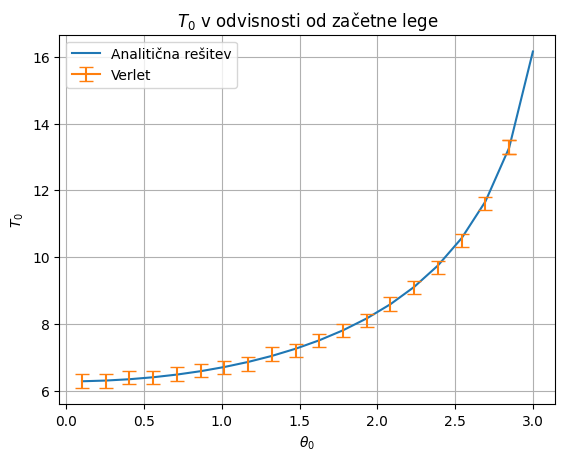

In [68]:
thetas = np.linspace(0.1, 3, 20)
T_0s = [T_0(theta) for theta in thetas]

plt.plot(thetas, T_0s, label='Analitična rešitev')
t = np.arange(0, 30, 0.1)
zero = 0
for i, theta_0 in enumerate(thetas):
    (x, v) = verlet(nihanje, theta_0, 0.0, t)
    peaks, _ = find_peaks(x)
    if len(peaks) < 2:
        continue
    t0 = t[peaks[1]] - t[peaks[0]]
    plt.errorbar(theta_0, t0, yerr=0.2, fmt='', c='C1', capsize=5)
    zero = t0
# add entries to legend
plt.errorbar(thetas[-2], zero, yerr=0.2, fmt='', c='C1', capsize=5, label='Verlet')
plt.title('$T_0$ v odvisnosti od začetne lege')
plt.xlabel('$\\theta_0$')
plt.ylabel('$T_0$')
plt.grid()
plt.legend()
plt.savefig('graphs/t0.pdf', dpi=512)



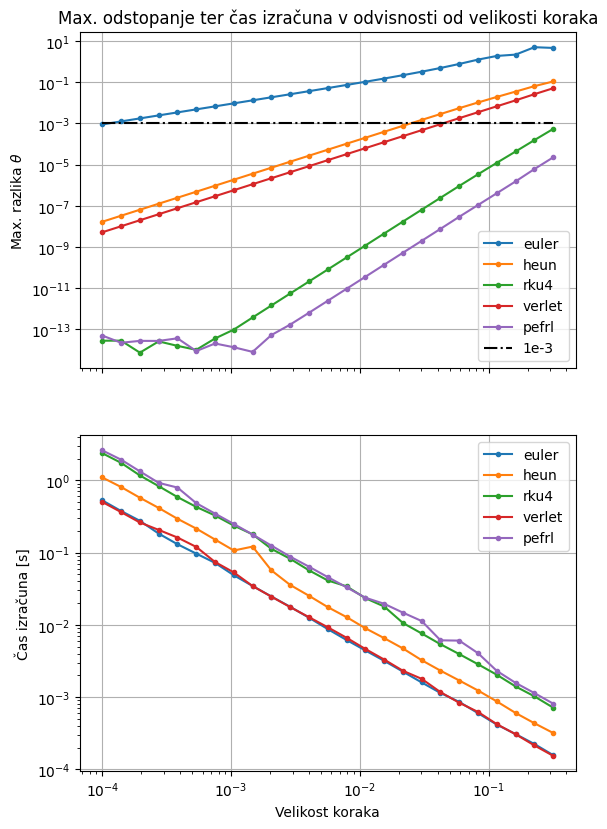

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 9.6), sharex=True)

ax1.set_title('Max. odstopanje ter čas izračuna v odvisnosti od velikosti koraka')
ax1.set_ylabel('Max. razlika $\\theta$')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.set_xlabel('Velikost koraka')
ax2.set_ylabel('Čas izračuna [s]')
ax2.set_yscale('log')
ax2.set_xscale('log')

for metoda in [euler, heun, rku4, verlet, pefrl]:
    step_size = np.logspace(-4, -0.5, 25)
    max_error = np.zeros_like(step_size)
    calc_time = np.zeros_like(step_size)
    for i, step in enumerate(step_size):
        start_time = timeit.default_timer()
        #print(f'{metoda.__name__} - {step}')
        t = np.arange(0, 15, step)
        if metoda in [euler, heun, rku4]:
            x_vec = metoda(nihanje_2, np.array([1., 0.]), t)
            x = x_vec[:, 0]
        else:
            (x, v) = metoda(nihanje, 1., 0., t)
        calc_time[i] = timeit.default_timer() - start_time
        y_anal = analytic(t)
        diff = np.abs(y_anal - x)
        max_error[i] = np.max(diff)

    ax1.plot(step_size, max_error, marker='.', label=f'{metoda.__name__}')
    ax2.plot(step_size, calc_time, marker='.', label=f'{metoda.__name__}')

ax1.hlines(1e-3, step_size[0], step_size[-1], color='black', linestyle='-.', label='1e-3')
ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
plt.savefig('graphs/double.pdf', dpi=512)

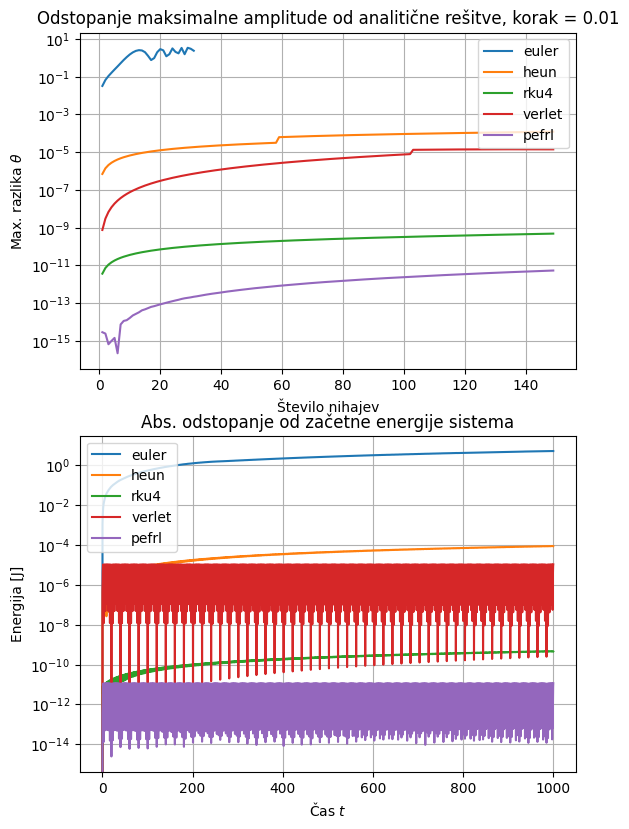

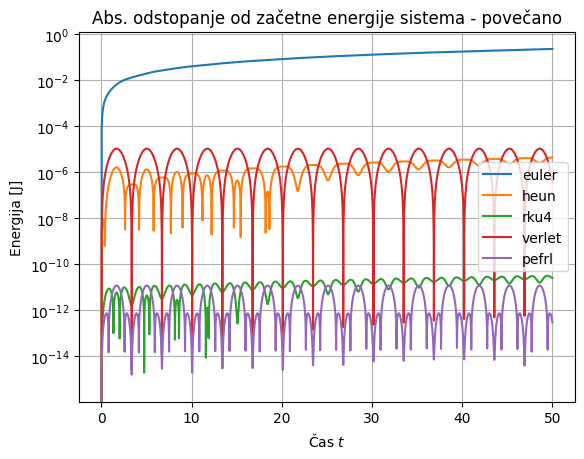

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 9.6))

fig, (ax3) = plt.subplots(1, 1, figsize=(6.4, 4.8))

ax1.set_title('Odstopanje maksimalne amplitude od analitične rešitve, korak = 0.01')
ax1.set_xlabel('Število nihajev')
ax1.set_ylabel('Max. razlika $\\theta$')
ax1.set_yscale('log')

ax2.set_title('Abs. odstopanje od začetne energije sistema')
ax2.set_xlabel('Čas $t$')
ax2.set_ylabel('Energija [J]')
ax2.set_yscale('log')

ax3.set_title('Abs. odstopanje od začetne energije sistema - povečano')
ax3.set_xlabel('Čas $t$')
ax3.set_ylabel('Energija [J]')
ax3.set_yscale('log')

for metoda in [euler, heun, rku4, verlet, pefrl]:
        
    t = np.arange(0, 1000, 0.01)
    if metoda in [euler, heun, rku4]:
        x_vec = metoda(nihanje_2, np.array([1., 0.]), t)
        x = x_vec[:, 0]
        v = x_vec[:, 1]
    else:
        (x, v) = metoda(nihanje, 1., 0., t)

    peaks, _ = find_peaks(x)
    theta = analytic(t)
    diff = np.abs(theta - x)
    indices = np.arange(len(t[peaks])) + 1
    E0 = 1.0 - np.cos(1.0)
    p=30
    energy = np.abs(1-np.cos(x)+v**2/2-E0)

    ax1.plot(indices, diff[peaks], label=f'{metoda.__name__}')
    ax2.plot(t[::p], energy[::p], label=f'{metoda.__name__}')
    ax3.plot(t[:5000], energy[:5000], label=f'{metoda.__name__}')    

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

plt.savefig('graphs/triple.pdf', dpi=512)

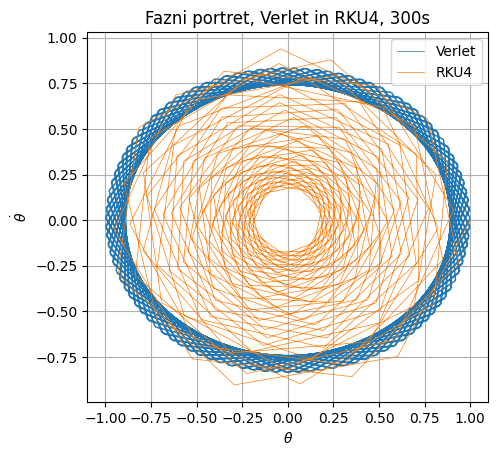

In [71]:
t = np.arange(0, 300, 1)
(x1, v1) = verlet(nihanje, 1., 0., t)
vec = rku4(nihanje_2, np.array([1., 0.]), t)
x2, v2 = vec[:, 0], vec[:, 1]

plt.plot(x1, v1, label='Verlet', linewidth=0.5)
plt.plot(x2, v2, label='RKU4', linewidth=0.5)

plt.grid()
plt.gca().set_aspect("equal")
plt.legend()

plt.xlabel('$\\theta$')
plt.ylabel('$\\dot{\\theta}$')
plt.title('Fazni portret, Verlet in RKU4, 300s')

plt.savefig('graphs/single.pdf', dpi=512)



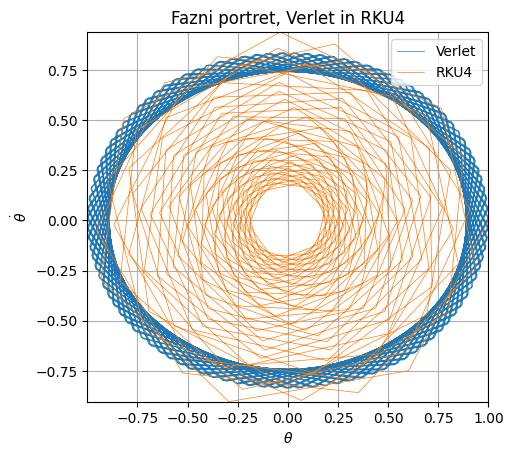

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### hvala chatGPT

# --- your existing data ---
t = np.arange(0, 300, 1)
(x1, v1) = verlet(nihanje, 1., 0., t)
vec = rku4(nihanje_2, np.array([1., 0.]), t)
x2, v2 = vec[:, 0], vec[:, 1]

# --- figure setup ---
fig, ax = plt.subplots()
ax.set_xlim(min(x1.min(), x2.min()), max(x1.max(), x2.max()))
ax.set_ylim(min(v1.min(), v2.min()), max(v1.max(), v2.max()))
ax.set_aspect("equal")
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\\dot{\\theta}$')
ax.set_title('Fazni portret, Verlet in RKU4')

line1, = ax.plot([], [], label='Verlet', linewidth=0.5)
line2, = ax.plot([], [], label='RKU4', linewidth=0.5)
ax.legend()
ax.grid()

# --- animation update function ---
def update(i):
    line1.set_data(x1[:i], v1[:i])
    line2.set_data(x2[:i], v2[:i])
    return line1, line2

# --- create animation ---
frames = len(t)
anim = FuncAnimation(fig, update, frames=frames, interval=20, blit=True)

# --- save animation (optional) ---
anim.save('graphs/single_animation.mp4', fps=30, dpi=200)

# plt.show()
# anim.save('single.gif', writer='imagemagick', fps=30)

